In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

import yaml
from hydra.experimental import compose, initialize_config_module
import hydra
import torch
from tqdm import tqdm
import json
import faiss
import logging
from collections import defaultdict
from dataclasses import dataclass
from typing import Optional, List, Dict, Any, Tuple

from bela.transforms.spm_transform import SPMTransform
from bela.evaluation.model_eval import ModelEval, load_file

logger = logging.getLogger(__name__)
!cat /etc/hostname  # Double check that we are on a gpu node

a100-st-p4d24xlarge-112


In [2]:
sp_transform = SPMTransform(max_seq_len=100000)


@dataclass
class GroundTruthEntity:
    offset: int
    length: int
    text: str
    entity_id: str

    @property
    def mention(self):
        return self.text[self.offset : self.offset + self.length]

    def __repr__(self):
        return f"mention={self.mention} -> entity_id={self.entity_id}"


@dataclass
class PredictedEntity:
    offset: int
    length: int
    text: str
    entity_id: str
    md_score: float
    el_score: float

    @property
    def mention(self):
        return self.text[self.offset : self.offset + self.length]

    def __repr__(self):
        return f"mention={self.mention} -> entity_id={self.entity_id} (md_score={self.md_score:.2f}, el_score={self.el_score:.2f})"


def print_sample(text: str, ground_truth_entities: List[GroundTruthEntity], predicted_entities: List[PredictedEntity], max_display_length=1000):
    print(f"{text[:max_display_length]=}")
    print("***************** Ground truth entities *****************")
    print(f"{len(ground_truth_entities)=}")
    for ground_truth_entity in ground_truth_entities:
        if ground_truth_entity.offset + ground_truth_entity.length > max_display_length:
            continue
        print(ground_truth_entity)
    print("***************** Predicted entities *****************")
    print(f"{len(predicted_entities)=}")
    for predicted_entity in predicted_entities:
        if predicted_entity.offset + predicted_entity.length > max_display_length:
            continue
        print(predicted_entity)


def get_windows(text):
    tokens = sp_transform([text])[0]
    tokens = tokens[1:-1]
    window_length = 254
    windows = []
    for window_start in range(0,len(tokens),window_length//2):
        start_pos = tokens[window_start][1]
        if window_start + window_length >= len(tokens):
            end_pos = tokens[-1][2]
        else:
            end_pos = tokens[window_start + window_length][2]
        windows.append((start_pos, end_pos))
    return windows

    
def convert_predictions_to_dict(example_predictions):
    predictions = []
    if len(example_predictions) > 0:
        offsets, lengths, entities, md_scores, el_scores = zip(*example_predictions) 
    else:
        offsets, lengths, entities, md_scores, el_scores = [], [], [], [], []
    return {
        'offsets': offsets,
        'lengths': lengths,
        'entities': entities,
        'md_scores': md_scores,
        'el_scores': el_scores,
    }


def group_predictions_by_example(all_predictions, extended_examples):
    grouped_predictions = defaultdict(list)
    for prediction, extended_example in zip(all_predictions, extended_examples):
        window_start = extended_example['window_start']
        prediction = dict(prediction)
        prediction['offsets'] = [offset + window_start for offset in prediction['offsets']]
        grouped_predictions[extended_example['document_id']].append((
            prediction
        ))
    
    predictions = {}
    for document_id, example_prediction_list in tqdm(grouped_predictions.items()):
        example_predictions = []
        for prediction in example_prediction_list:
            for offset,length,ent,md_score,el_score in zip(
                prediction['offsets'],
                prediction['lengths'],
                prediction['entities'],
                prediction['md_scores'],
                prediction['el_scores'],
            ):
                example_predictions.append((offset,length,ent,md_score,el_score))
                example_predictions = sorted(example_predictions)
        predictions[document_id] = example_predictions
        
    return predictions


def merge_predictions(example_predictions):
    filtered_example_predictions = []

    current_end = None
    current_offset = None
    current_length = None
    current_ent_id = None
    current_md_score = None
    current_el_score = None

    for offset,length,ent_id,md_score,el_score in example_predictions:
        if current_end is None:
            current_end = offset + length
            current_offset = offset
            current_length = length
            current_ent_id = ent_id
            current_md_score = md_score
            current_el_score = el_score
            continue

        if offset < current_end:
            # intersection of two predictions
            if md_score > current_md_score:
                current_ent_id = ent_id
                current_offset = offset
                current_length = length
                current_md_score = md_score
                current_el_score = el_score
        else:
            filtered_example_predictions.append((
                current_offset,
                current_length,
                current_ent_id,
                current_md_score,
                current_el_score
            ))
            current_ent_id = ent_id
            current_offset = offset
            current_length = length
            current_md_score = md_score
            current_el_score = el_score

        current_end = offset+length

    if current_offset is not None:
        filtered_example_predictions.append((
            current_offset,
            current_length,
            current_ent_id,
            current_md_score,
            current_el_score
        ))
    
    return filtered_example_predictions

def safe_division(a, b):
    if b == 0:
        return 0
    else:
        return a / b


def compute_f1_p_r(tp, fp, fn):
    precision = safe_division(tp, (tp + fp))
    recall = safe_division(tp, (tp + fn))
    f1 = safe_division(2 * tp, (2 * tp + fp + fn))
    return f1, precision, recall

def compute_scores(data, predictions, md_threshold=0.2, el_threshold=0.05):
    tp, fp, support = 0, 0, 0
    tp_boe, fp_boe, support_boe = 0, 0, 0

    predictions_per_example = []
    for example, example_predictions in zip(data, predictions):

        example_targets = {
            (offset,length):ent_id
            for _,_,ent_id,_,offset,length in example['gt_entities']
        }

        example_predictions = {
            (offset, length):ent_id
            for offset, length, ent_id, md_score, el_score in zip(
                example_predictions['offsets'],
                example_predictions['lengths'],
                example_predictions['entities'],
                example_predictions['md_scores'],
                example_predictions['el_scores'],
            )
            if (el_score > el_threshold and md_score > md_threshold) 
        }

        predictions_per_example.append((len(example_targets), len(example_predictions)))

        for pos, ent in example_targets.items():
            support += 1
            if pos in example_predictions and example_predictions[pos] == ent:
                tp += 1
        for pos, ent in example_predictions.items():
            if pos not in example_targets or example_targets[pos] != ent:
                fp += 1

        example_targets_set = set(example_targets.values())
        example_predictions_set = set(example_predictions.values())

        for ent in example_targets_set:
            support_boe += 1
            if ent in example_predictions_set:
                tp_boe += 1
        for ent in example_predictions_set:
            if ent not in example_targets_set:
                fp_boe += 1

    fn = support - tp
    fn_boe = support_boe - tp_boe
    return compute_f1_p_r(tp, fp, fn), compute_f1_p_r(tp_boe, fp_boe, fn_boe)


def compute_md_scores(data, predictions, md_threshold=0.2):
    tp, fp, support = 0, 0, 0

    predictions_per_example = []
    for example, example_predictions in zip(data, predictions):

        example_targets = {
            (offset,length):ent_id
            for _,_,ent_id,_,offset,length in example['gt_entities']
        }

        example_predictions = {
            (offset, length):ent_id
            for offset, length, ent_id, md_score in zip(
                example_predictions['offsets'],
                example_predictions['lengths'],
                example_predictions['entities'],
                example_predictions['md_scores'],
            )
            if (md_score > md_threshold) 
        }

        predictions_per_example.append((len(example_targets), len(example_predictions)))

        for pos in example_targets.keys():
            support += 1
            if pos in example_predictions:
                tp += 1
        for pos in example_predictions.keys():
            if pos not in example_targets:
                fp += 1

    fn = support - tp
    return compute_f1_p_r(tp, fp, fn)


def correct_mention_offsets(example_predictions, text):
    TEXT_SEPARATORS = [' ','.',',','!','?','-','\n']
    corrected_example_predictions = []
    for offset,length,ent_id,md_score,el_score in example_predictions:
        while offset !=0 and offset<len(text) and (text[offset-1] not in TEXT_SEPARATORS or text[offset] in TEXT_SEPARATORS):
            offset += 1
            length -= 1
        while offset+length < len(text) and text[offset+length] not in TEXT_SEPARATORS:
            length += 1
        corrected_example_predictions.append((
            offset,length,ent_id,md_score,el_score
        ))
    return corrected_example_predictions


def get_predictions_using_windows(test_data, batch_size=1024):
    extended_examples = []

    for example in test_data:
        text = example['original_text']
        windows = get_windows(text)
        for idx, (start_pos, end_pos) in enumerate(windows):
            new_text = text[start_pos:end_pos]
            extended_examples.append({
                'document_id': example['document_id'] if 'document_id' in example else example['data_example_id'],
                'original_text': new_text,
                'gt_entities': example['gt_entities'],
                'window_idx': idx,
                'window_start': start_pos,
                'window_end': end_pos,
            })

    all_predictions = model_eval.get_predictions(extended_examples, batch_size=batch_size)
    predictions_dict = group_predictions_by_example(all_predictions, extended_examples)

    predictions = []
    for example in test_data:
        document_id = example['document_id']  if 'document_id' in example else example['data_example_id']
        text = example['original_text']
        example_predictions = predictions_dict[document_id]
        example_predictions = merge_predictions(example_predictions)
        example_predictions = correct_mention_offsets(example_predictions, text)
        example_predictions = convert_predictions_to_dict(example_predictions)
        predictions.append(example_predictions)

    return predictions


def shift_shift(text):
    for idx,ch in enumerate(text):
        if not ch.isalpha():
            return idx

def convert_data_for_disambiguation(data, lang):
    # convert examples to 1 entity per example and shift if needed
    if lang=='ar':
        MAX_LENGTH = 600
        MAX_OFFSET = 400
    elif lang == 'ja':
        MAX_LENGTH = 350
        MAX_OFFSET = 250
    else:
        MAX_LENGTH = 800
        MAX_OFFSET = 600
    new_examples = []
    for example in tqdm(data):
        original_text = example['original_text']
        for _, _, ent, _, offset, length in example['gt_entities']:
            shift = 0
            if len(original_text) > MAX_LENGTH and offset > MAX_OFFSET:
                shift = (offset - MAX_OFFSET)
                shift += shift_shift(original_text[shift:])
            new_example = {
                'original_text': original_text[shift:],
                'gt_entities': [[0,0,ent,_,offset-shift,length]],
            }
            new_examples.append(new_example)
    return new_examples


def metrics_disambiguation(test_data, predictions):
    support = 0
    support_only_predicted = 0
    correct = 0
    incorrect_pos = 0

    for example_idx, (example, prediction) in tqdm(enumerate(zip(test_data, predictions))):
#         targets = {
#             (offset,length):ent_id
#             for _,_,ent_id,_,offset,length in example['gt_entities']
#         }
#         prediction = {
#             (offset,length):ent_id
#             for offset,length,ent_id in zip(prediction['offsets'], prediction['lengths'], prediction['entities'])
#         }

#         support += len(targets)
#         support_only_predicted += len(prediction)
        
#         correct += sum(1 for pos,ent_id in prediction.items() if (pos in targets and targets[pos] == ent_id))
#         incorrect_pos += sum(1 for pos,_ in prediction.items() if pos not in targets)
        if len(prediction['entities']) == 0:
            continue
        target = example['gt_entities'][0][2]
        prediction = prediction['entities'][0]
        correct += (target == prediction)
        support += 1

    accuracy = correct/support
    # accuracy_only_predicted = correct/support_only_predicted

    return accuracy, support #, accuracy_only_predicted, support_only_predicted

# Load model

In [3]:
%%prun -s tottime -l 20

# e2e model with isotropic embeddings
#checkpoint_path = '/checkpoints/movb/bela/2023-01-13-023711/0/lightning_logs/version_4144/checkpoints/last.ckpt'  # Not working: Unexpected key(s) in state_dict: "saliency_encoder.mlp.0.weight", "saliency_encoder.mlp.0.bias", "saliency_encoder.mlp.3.weight", "saliency_encoder.mlp.3.bias", "saliency_encoder.mlp.6.weight", "saliency_encoder.mlp.6.bias". 
#checkpoint_path = '/checkpoints/movb/bela/2022-11-27-225013/0/lightning_logs/version_286287/checkpoints/last_15000.ckpt'  # Works but 0 F1

# E2E checkpoint with new embeddings
# https://fb.quip.com/QVUxA4UcAZ7k#temp:C:OcG977f71fab43d42379521a0dff
# Works but give 0 F1 on tackbp (mention detection is okish, but entity disambiguation is random)
checkpoint_path = '/checkpoints/movb/bela/2023-01-18-220105/0/lightning_logs/version_4820/checkpoints/last.ckpt'
#model_eval = ModelEval(checkpoint_path, config_name="joint_el_mel_new")
model_eval = ModelEval(checkpoint_path, config_name="joint_el_mel_new_index")

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


         169715971 function calls (169649055 primitive calls) in 114.955 seconds

   Ordered by: internal time
   List reduced from 6679 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        3   26.541    8.847   55.344   18.448 joint_el_datamodule.py:47(__init__)
 44771119   23.365    0.000   23.365    0.000 {method 'readline' of 'mmap.mmap' objects}
       67   13.191    0.197   13.195    0.197 serialization.py:1076(load_tensor)
        1   12.126   12.126   12.126   12.126 {built-in method faiss._swigfaiss.GpuIndexFlat_add}
        1   10.762   10.762   11.764   11.764 joint_el_datamodule.py:21(__init__)
 61309509    3.522    0.000    3.522    0.000 {method 'append' of 'list' objects}
        1    3.462    3.462    3.462    3.462 {built-in method faiss._swigfaiss.new_GpuIndexFlatIP}
        1    2.772    2.772  114.959  114.959 model_eval.py:60(__init__)
 44771116    2.746    0.000    2.746    0.000 {method 'tell' of 'mmap.mma

In [4]:
# Set thresholds
model_eval.task.md_threshold = 0.05
model_eval.task.el_threshold = 0.05

# End-to-end Eval

In [ ]:
print(f"{model_eval.checkpoint_path=}")
print(f"{model_eval.task.md_threshold=}")
print(f"{model_eval.task.el_threshold=}")
datasets = [
    "/fsx/louismartin/bela/retrieved_from_aws_backup/ndecao/TACKBP2015/train_bela_format.jsonl",
    #'/fsx/movb/data/matcha/mewsli-9/ta.jsonl',
    #'/fsx/movb/data/matcha/mewsli-9/ar.jsonl',
    '/fsx/movb/data/matcha/mewsli-9/en.jsonl',
    #'/fsx/movb/data/matcha/mewsli-9/fa.jsonl',
    #'/fsx/movb/data/matcha/mewsli-9/sr.jsonl',
    #'/fsx/movb/data/matcha/mewsli-9/tr.jsonl',
    #'/fsx/movb/data/matcha/mewsli-9/de.jsonl',
    #'/fsx/movb/data/matcha/mewsli-9/es.jsonl',
    #'/fsx/movb/data/matcha/mewsli-9/ja.jsonl',
]
for test_data_path in datasets:
    print(f"Processing {test_data_path}")
    test_data = load_file(test_data_path)
    test_data = test_data[:1000]
    
    predictions = get_predictions_using_windows(test_data)
    (f1, precision, recall), (f1_boe, precision_boe, recall_boe) = compute_scores(test_data, predictions)
    
    print(f"F1 = {f1:.4f}, precision = {precision:.4f}, recall = {recall:.4f}")
    print(f"F1 boe = {f1_boe:.4f}, precision = {precision_boe:.4f}, recall = {recall_boe:.4f}")

# Disambiguation Eval

In [ ]:
datasets = [
    '/fsx/movb/data/matcha/mewsli-9/ta.jsonl',
    '/fsx/movb/data/matcha/mewsli-9/ar.jsonl',
    '/fsx/movb/data/matcha/mewsli-9/en.jsonl',
    '/fsx/movb/data/matcha/mewsli-9/fa.jsonl',
    '/fsx/movb/data/matcha/mewsli-9/sr.jsonl',
    '/fsx/movb/data/matcha/mewsli-9/tr.jsonl',
    '/fsx/movb/data/matcha/mewsli-9/de.jsonl',
    '/fsx/movb/data/matcha/mewsli-9/es.jsonl',
    '/fsx/movb/data/matcha/mewsli-9/ja.jsonl',
]
for test_data_path in datasets:
    print(f"Processing {test_data_path}")
    lang = test_data_path[-8:-6]
    test_data = load_file(test_data_path)
    test_data = convert_data_for_disambiguation(test_data[:10000], lang)
    predictions = model_eval.get_disambiguation_predictions(test_data)
    accuracy, support = metrics_disambiguation(test_data, predictions)
    print(f"Accuracty {accuracy}, support {support}")

# Mention Detection Eval

In [5]:
model_eval.task.md_threshold = 0.2
model_eval.task.el_threshold = 0.0
print(f"{model_eval.checkpoint_path=}")
print(f"{model_eval.task.md_threshold=}")
print(f"{model_eval.task.el_threshold=}")
datasets = [
    # "/fsx/louismartin/bela/retrieved_from_aws_backup/ndecao/TACKBP2015/train_bela_format.jsonl",
    '/fsx/movb/data/matcha/mel/test.1st.txt'
]
for test_data_path in datasets:
    print(f"Processing {test_data_path}")
    test_data = load_file(test_data_path)
    test_data = test_data[:1000]
    
    predictions = get_predictions_using_windows(test_data)
    (f1, precision, recall) = compute_md_scores(test_data, predictions)
    
    print(f"F1 = {f1:.4f}, precision = {precision:.4f}, recall = {recall:.4f}")

model_eval.checkpoint_path='/checkpoints/movb/bela/2023-01-18-220105/0/lightning_logs/version_4820/checkpoints/last.ckpt'
model_eval.task.md_threshold=0.2
model_eval.task.el_threshold=0.0
Processing /fsx/movb/data/matcha/mel/test.1st.txt


42902it [00:01, 27068.75it/s]
100%|██████████| 999/999 [00:00<00:00, 2931.99it/s]

F1 = 0.1328, precision = 0.2119, recall = 0.0967


# Rejection head ablation study

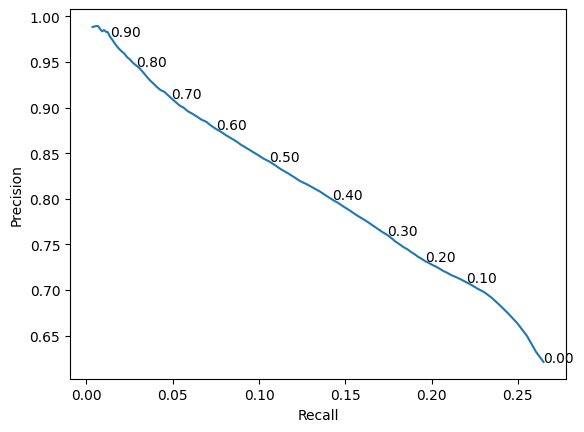

In [21]:
import matplotlib.pyplot as plt
import numpy as np


model_eval.task.md_threshold = 0.05
model_eval.task.el_threshold = 0.00
datasets = [
    # "/fsx/louismartin/bela/retrieved_from_aws_backup/ndecao/TACKBP2015/train_bela_format.jsonl",
    '/fsx/movb/data/matcha/mel/test.1st.txt'
    #'/fsx/movb/data/matcha/mewsli-9/en.jsonl',
]
for test_data_path in datasets:
    print(f"Processing {test_data_path}")
    test_data = load_file(test_data_path)
    #test_data = test_data[:1000]
    
    predictions = get_predictions_using_windows(test_data)
    
    """
    (f1, precision, recall), (f1_boe, precision_boe, recall_boe) = compute_scores(test_data, predictions, el_threshold=0.5)
    print(f"F1 = {f1:.4f}, precision = {precision:.4f}, recall = {recall:.4f}")
    print(f"F1 boe = {f1_boe:.4f}, precision = {precision_boe:.4f}, recall = {recall_boe:.4f}")
    
    print(f"Without rejection head")
    (f1, precision, recall), (f1_boe, precision_boe, recall_boe) = compute_scores(test_data, predictions, el_threshold=0.0)
    print(f"F1 = {f1:.4f}, precision = {precision:.4f}, recall = {recall:.4f}")
    print(f"F1 boe = {f1_boe:.4f}, precision = {precision_boe:.4f}, recall = {recall_boe:.4f}")
    """
    
    el_thresholds = np.arange(0.0, 1.0, 0.01)
    precision = []
    recall = []
    for el_threshold in el_thresholds:
        _, (_, precision_boe, recall_boe) = compute_scores(test_data, predictions, el_threshold=el_threshold)
        precision.append(precision_boe)
        recall.append(recall_boe)
        
    plt.plot(recall, precision)
    for x,y, th in zip(recall[::10], precision[::10], el_thresholds[::10]): 
        plt.text(x, y, f'{th:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    

In [15]:
sum([len(e['gt_entities']) for e in test_data])

246524

# Inference time

In [ ]:
def batch_samples(samples, batch_size):
    # Yield batches of samples
    for i in range(0, len(samples), batch_size):
        yield samples[i : i + batch_size]


texts = [sample["original_text"] for sample in load_file("/fsx/movb/data/matcha/mewsli-9/en.jsonl")]
batch_size = 1024
print(f"Processing {len(texts)} texts, {batch_size=}, {model_eval.transform.max_seq_len=}")
%time _ = [model_eval.process_batch(batch_texts) for batch_texts in tqdm(batch_samples(texts, batch_size), desc="Inference")]

## Debug some samples

In [ ]:
text = "Taylor Swift lives in New York City. New York City is a city in the United States."
prediction = model_eval.process_batch([text])[0]
predicted_entities = [PredictedEntity(offset, length, text, entity_id, md_score, el_score) for offset, length, entity_id, md_score, el_score in zip(prediction["offsets"], prediction["lengths"], prediction["entities"], prediction["md_scores"], prediction["el_scores"])]
print_sample(text, [], predicted_entities)

In [ ]:

test_data_path = "/fsx/louismartin/bela/retrieved_from_aws_backup/ndecao/TACKBP2015/train_bela_format.jsonl"
print(f"Processing {test_data_path}")
test_data = load_file(test_data_path)
sample = test_data[200]
prediction = get_predictions_using_windows([sample])[0]
text = sample["original_text"]
max_length = 1024

ground_truth_entities = [GroundTruthEntity(offset, length, text, entity_id) for _, _, entity_id, _, offset, length in sample["gt_entities"]]
predicted_entities = [PredictedEntity(offset, length, text, entity_id, md_score, el_score) for offset, length, entity_id, md_score, el_score in zip(prediction["offsets"], prediction["lengths"], prediction["entities"], prediction["md_scores"], prediction["el_scores"])]
print_sample(text, ground_truth_entities, predicted_entities, max_display_length=1000)

# Draft